# Recall Rates for Medical Device Manufacturers

## Project Overview:

Searching for correlations between Device Implantable status and Recall Rates. 

Background: Device failures can result in Field Safety Notices being issued to the affected customer population, warning them of any safety issues and providing recommended guidance to mitigate them. If issues are sufficiently serious, they may lead to the devices being pulled off the market via Recalls.

Question: Are failures with Implantable devices more likely to result in Recalls?



In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#creating source dataframes
devices = pd.read_csv('devices-1681209661.csv')
events = pd.read_csv('events-1681209680.csv', dtype=str)
manuf = pd.read_csv('manufacturers-1681209657.csv', index_col=0)

display(events.head(2))
display(devices.head(2))
display(manuf.head(2))


,id,action,action_classification,action_level,action_summary,authorities_link,country,create_date,data_notes,date,...,status,target_audience,type,uid,uid_hash,url,slug,device_id,created_at,updated_at
0,1,NaN,NaN,NaN,Recall,https://www.titck.gov.tr/,TUR,NaN,NaN,2016-04-04,...,NaN,NaN,Field Safety Notice,2016/294 & FA24MAR2016,41570514,https://web.archive.org/web/20170817053524/htt...,tur-cell-dyn-emerald-cleanser,1,2022-08-04 08:28:00 UTC,2022-08-04 08:28:00 UTC
1,2,NaN,NaN,NaN,Recall,https://www.titck.gov.tr/,TUR,NaN,NaN,2016-09-20,...,NaN,NaN,Field Safety Notice,2016/844 & FSCA2016-02,415f04f4,https://web.archive.org/web/20170817104322/htt...,tur-tecnis-monofocal-1-piece-tecnis-1-piece-io...,2,2022-08-04 08:28:00 UTC,2022-08-04 08:28:00 UTC


,id,classification,code,description,distributed_to,implanted,name,number,quantity_in_commerce,risk_class,slug,country,manufacturer_id,created_at,updated_at
0,1,NaN,NaN,IVD Other,NaN,NaN,Cell-Dyn Emerald Cleanser,NaN,NaN,NaN,tur-cell-dyn-emerald-cleanser,TUR,1,2022-08-04 08:28:00 UTC,2022-08-04 08:28:00 UTC
1,2,NaN,NaN,Class IIB,NaN,NaN,"TECNIS Monofocal 1-piece, TECNIS 1-Piece IOL w...",NaN,NaN,NaN,tur-tecnis-monofocal-1-piece-tecnis-1-piece-io...,TUR,2,2022-08-04 08:28:00 UTC,2022-08-04 08:28:00 UTC


,address,comment,name,parent_company,representative,slug,source,created_at,updated_at
id,,,,,,,,,
1,NaN,“We are in constant communication with regulat...,Abbot Laboratories,Abbott Laboratories,NaN,turkey-drugs-and-medical-devices-agency-titck-...,Turkey Drugs and Medical Devices Agency (Titck),2022-08-04 08:28:00 UTC,2022-08-04 08:28:00 UTC
2,NaN,NaN,Abbott Medical Optics (AMO) Inc.,Johnson & Johnson,NaN,turkey-drugs-and-medical-devices-agency-titck-...,Turkey Drugs and Medical Devices Agency (Titck),2022-08-04 08:28:00 UTC,2022-08-04 08:28:00 UTC


In [50]:
#filtering source dataframes to remove unnecessary columns, changing column titles and data types to support merging of dataframes
devices = devices.loc[:, ['id','description','implanted','name','country','manufacturer_id','created_at','updated_at']]
devices = devices.rename(columns={'id':'device_id'})
devices['device_id'] = devices['device_id'].astype(str)
devices = devices.set_index('device_id')

events = events.loc[:,['id','country','data_notes','date','type','device_id']] #'type' column has no NaN values, and can be better relied upon to determine the outcome of an event
events['device_id'] = events['device_id'].astype(str)
events = events.set_index('device_id')

manuf = manuf.loc[:, ['name','parent_company']]


#merging source data to produce final dataframe, removing any remaining unnecessary columns and editing content. 
events_devices = pd.merge(events,devices,left_on='device_id', right_on='device_id',how='left')
final_events = pd.merge(events_devices, manuf, left_on='manufacturer_id',right_on='id',how='left')
final_events = final_events.rename(columns={'name_y':'company'})
final_events = final_events.loc[:,['country_x','data_notes', 'date','type','description','implanted','manufacturer_id','company','parent_company']]
final_events['company / parent'] = final_events['company'] + ' / ' + final_events['parent_company'] #concatenating company columns
final_events = final_events.drop('company', axis=1)
final_events = final_events.drop('parent_company', axis=1)

#Simplifying event types to either "Recall" or "Safety Alert..." descriptors.
final_events.type = final_events.type.replace('Field Safety Notice','Safety Alert / Field Safety Notice')
final_events.type = final_events.type.replace('Safety Alert','Safety Alert / Field Safety Notice')
final_events.type = final_events.type.replace('Safety alert','Safety Alert / Field Safety Notice')
final_events.type = final_events.type.replace('Safety alert / Field Safety Notice','Safety Alert / Field Safety Notice')
final_events.type = final_events.type.replace('Recall / Safety Alert','Recall')
final_events.type = final_events.type.replace('Recall / Safety alert','Recall')
final_events.type = final_events.type.replace('Recall / Field Safety Notice','Recall')

display(final_events)


,country_x,data_notes,date,type,description,implanted,manufacturer_id,company / parent
0,TUR,NaN,2016-04-04,Safety Alert / Field Safety Notice,IVD Other,NaN,1,Abbot Laboratories / Abbott Laboratories
1,TUR,NaN,2016-09-20,Safety Alert / Field Safety Notice,Class IIB,NaN,2,Abbott Medical Optics (AMO) Inc. / Johnson & J...
2,TUR,NaN,2016-05-09,Safety Alert / Field Safety Notice,Class IIA,NaN,3,Alcon Laboratories Inc. / Novartis Ag
3,TUR,NaN,2016-12-19,Safety Alert / Field Safety Notice,Class IIB,NaN,4,NaN
4,TUR,NaN,2017-02-20,Safety Alert / Field Safety Notice,IVD Other,NaN,5,NaN
...,...,...,...,...,...,...,...,...
124964,MYS,RECALL: DePuy Spine Confidence Introducer Nee...,NaN,Recall,NaN,NaN,31799,Johnson & Johnson / Cardinal Health
124965,MYS,RECALL: VICRYL RAPIDE SUTURES1. Letter from MD...,NaN,Recall,NaN,NaN,31799,Johnson & Johnson / Cardinal Health
124966,MYS,RECALL: Medtronic Model 990018 Multi-Channel R...,NaN,Recall,NaN,NaN,31812,Medtronic International Ltd. / Medtronic plc
124967,MYS,RECALL: Arrow Ultra 8 Intra-Aortic Balloon Cat...,2011-02-08,Recall,NaN,NaN,31808,Arrow International Inc / Teleflex Incorporated


Recall Rate for Implantable Devices: 79.95%
Recall Rate for Non-Implantable Devices: 100.00%


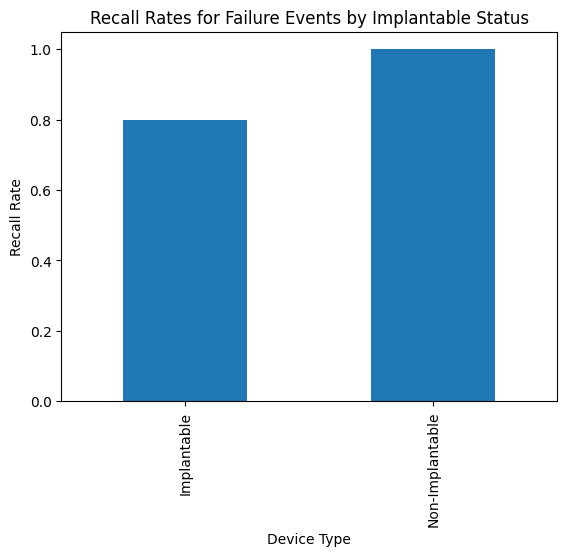

In [51]:
#flexible function for calculating the recall rate based on a given dataframe column's values
def calculate_recall_rate(df, col, value):
    subset = df[df[col] == value]  # Filter implantable or not
    recall_count = subset[subset["type"] == "Recall"].shape[0]  # Count recalls
    total_count = subset.shape[0]  # Count total events
    recall_rate = recall_count / total_count if total_count > 0 else 0
    return recall_rate

implantable_recall_rate = calculate_recall_rate(final_events, 'implanted', 'YES')
nonimplantable_recall_rate = calculate_recall_rate(final_events, 'implanted', 'NO')

print(f"Recall Rate for Implantable Devices: {implantable_recall_rate:.2%}")
print(f"Recall Rate for Non-Implantable Devices: {nonimplantable_recall_rate:.2%}")




df = {'Device Type':['Implantable','Non-Implantable'],
      'Recall Rate': [implantable_recall_rate, nonimplantable_recall_rate]}
df = pd.DataFrame(df)

df.plot(kind='bar', x='Device Type', y='Recall Rate', legend=False)
plt.xlabel('Device Type')
plt.ylabel('Recall Rate')
plt.title('Recall Rates for Failure Events by Implantable Status')
plt.show()

## Analysis and Insights:

All events for Non-Implantable devices led to Recalls, in contrast to only 80% of Implantable devices. There does not appear to be a correlation. 

This might suggest that more stringent regulatory standards for implantable devices result in better designed product with lower serious failure rates.


##NOTE: No summary statistics (mean, median, min, max) were calculated due to the nature of the source dataframe and the absence of numerical columns that provided information other than references to another dataframe (such as the numbers that reference specific manufacturers in the Device dataframe)


## Conclusion and Recommendations:

Implantable status has no bearing on Recall rate

Recommend sourcing additional data on specific device intended uses, material makeup, lifecycle, to support a more detailed assessment of any pertinent correlations. 